In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
df = pd.read_csv("apple_data_test.csv")
open_prices = df.Open
dates = pd.to_datetime(df.Date, dayfirst= True)

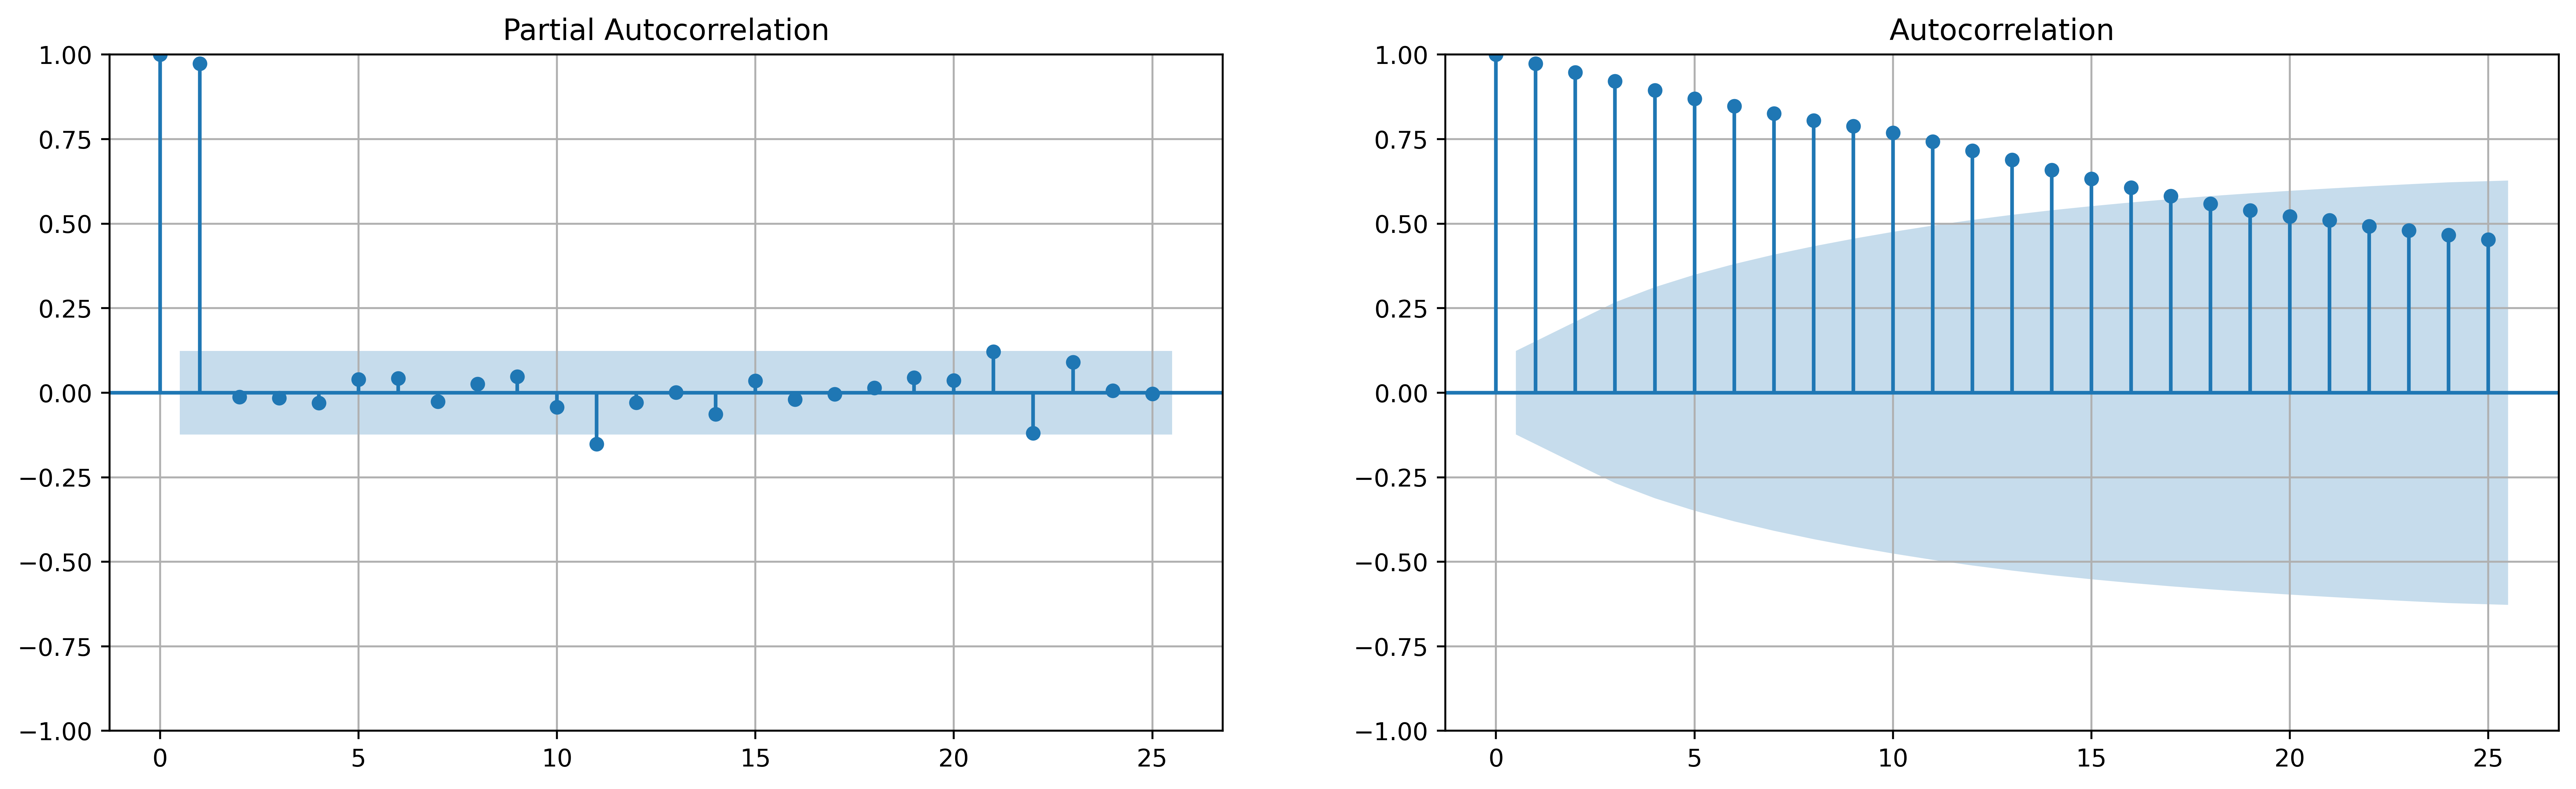

In [3]:
plt.rcParams.update({'figure.dpi' : 500})
f = plt.figure(figsize= (18, 5))

ax1 = f.add_subplot(121)
plot_pacf(open_prices, ax= ax1, method= "ywm");
plt.grid(True)

ax2 = f.add_subplot(122)
plot_acf(open_prices, ax= ax2);
plt.grid(True)

plt.show()

## Проверка стационарности

In [4]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="BIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [5]:
# тестирование ADF стационарности
adf_test(open_prices)

Results of Dickey-Fuller Test:
Test Statistic                   0.017149
p-value                          0.959927
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [6]:
# тестирование KPSS стационарности
kpss_test(open_prices);

Results of KPSS Test:


/home/andrew/dev_env/std_env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic            1.801544
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [7]:
# переход к первым разностям
diff1_open_prices = open_prices.diff().dropna()

In [8]:
# тестирование ADF стационарности
adf_test(diff1_open_prices)

Results of Dickey-Fuller Test:
Test Statistic                -1.707397e+01
p-value                        7.790100e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


In [9]:
# тестирование KPSS стационарности
kpss_test(diff1_open_prices);

Results of KPSS Test:


/home/andrew/dev_env/std_env/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic           0.238854
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


## ACF и PACF

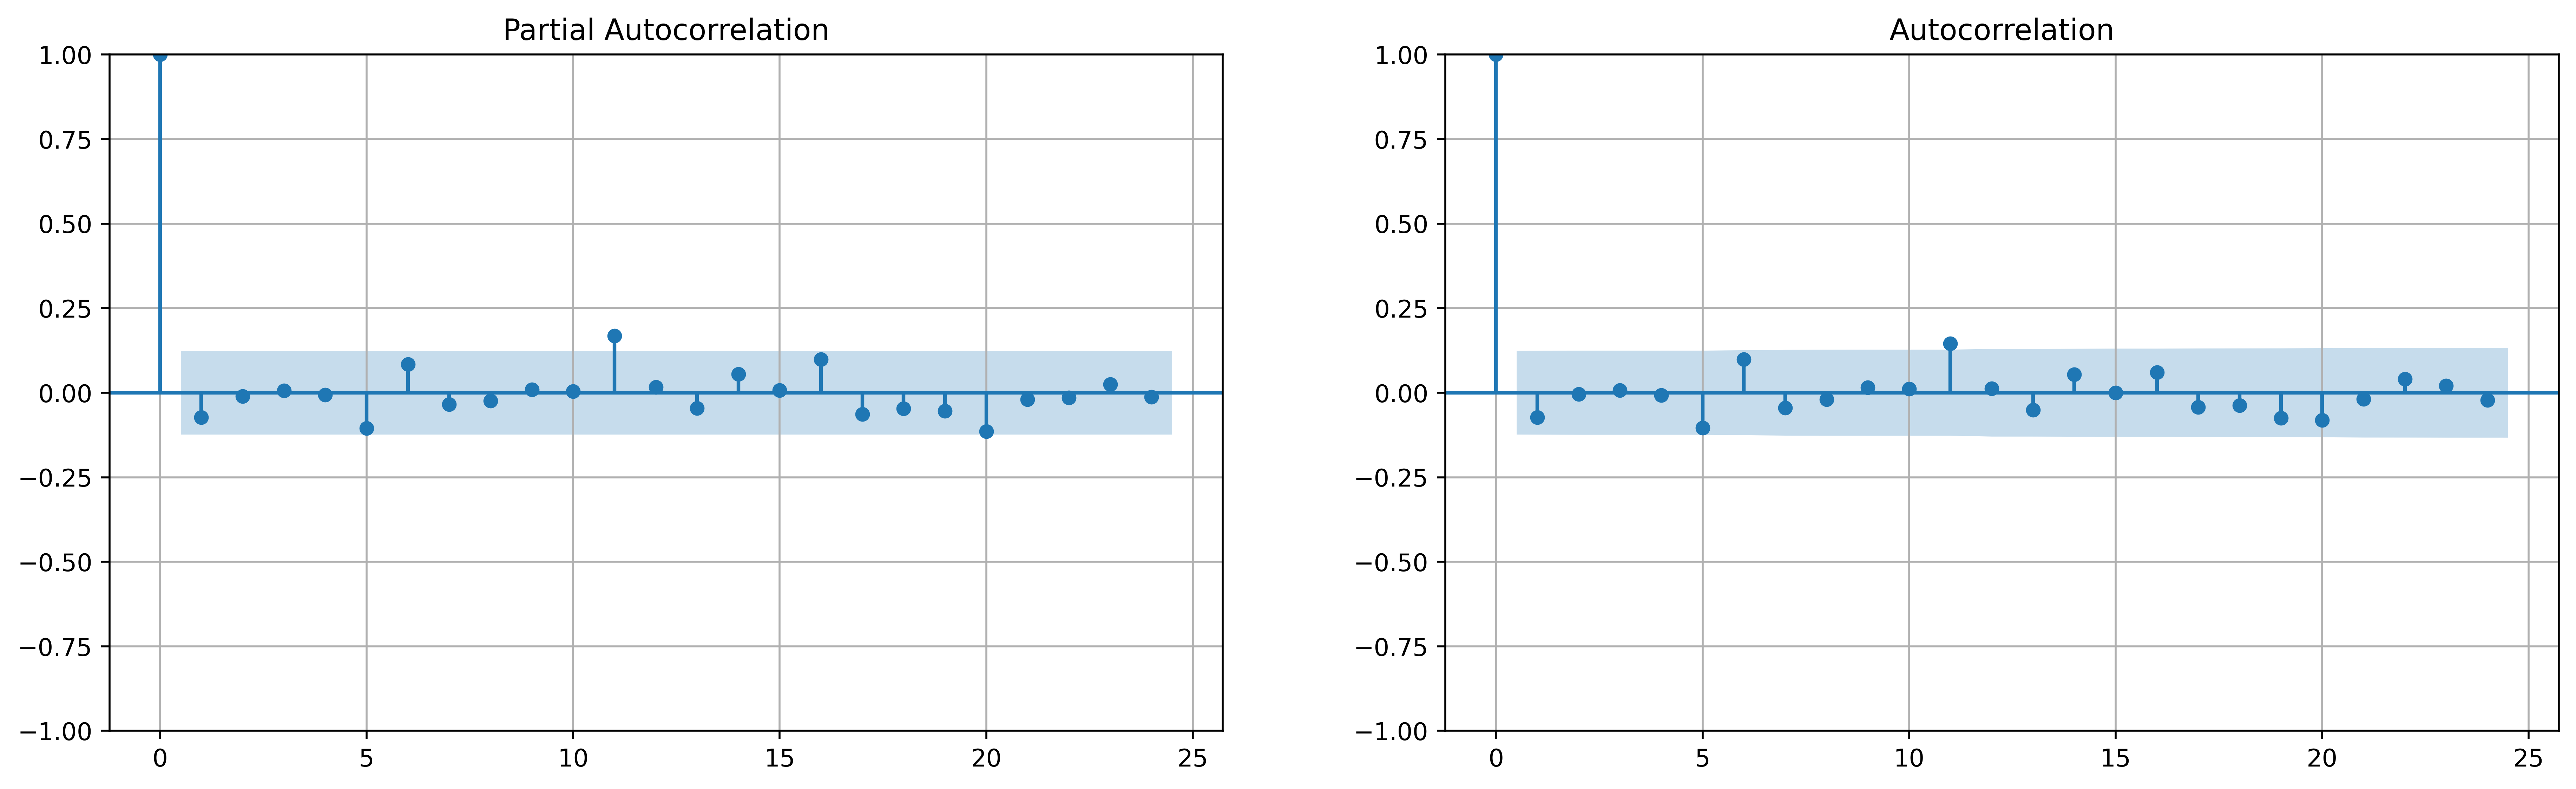

In [10]:
f = plt.figure(figsize= (18, 5))

ax1 = f.add_subplot(121)
plot_pacf(diff1_open_prices, ax= ax1, method= "ywm");
plt.grid(True)

ax2 = f.add_subplot(122)
plot_acf(diff1_open_prices, ax= ax2);
plt.grid(True)

plt.savefig("initial_acf_pacf.png", dpi=180)
plt.show()

# Оценка моделей

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
# ARIMA(0, 1, 0)
limit_size = -30

data_train = open_prices[:limit_size]
data_test = open_prices[limit_size:]

dates_train = dates[:limit_size]
dates_test = dates[limit_size:]

arima_model = ARIMA(data_train, order= (0, 1, 0), trend= "t")
model = arima_model.fit(cov_type= "robust")

In [12]:
from statsmodels.stats.sandwich_covariance import cov_hac
model.__setattr__("cov_params_robust", cov_hac(model))
model.__setattr__("cov_params", cov_hac(model))

In [13]:
model.cov_params_robust

array([[ 816.97827885, -239.32475767],
       [-239.32475767, 9910.84538225]])

In [14]:
model.test_heteroskedasticity(method= None)

array([[0.50545235, 0.00376463]])

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  222
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -465.355
Date:                Thu, 16 Feb 2023   AIC                            934.710
Time:                        21:18:10   BIC                            941.506
Sample:                             0   HQIC                           937.454
                                - 222                                         
Covariance Type:               robust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0791      0.134      0.592      0.554      -0.183       0.341
sigma2         3.9490      0.439      9.000      0.000       3.089       4.809
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.50
Prob(Q):                              0.83   Prob(JB):                         0.04
Heteroskedasticity (H):               0.51   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Quasi-maximum likelihood covariance matrix used for robustness to some misspecifications; calculated using the observed information matrix (complex-step) described in Harvey (1989).
"""

In [17]:
model.cov_params

array([[ 816.97827885, -239.32475767],
       [-239.32475767, 9910.84538225]])

In [18]:
model.normalized_cov_params

,x1,sigma2
x1,NaN,NaN
sigma2,NaN,NaN


In [ ]:
f = plt.figure(figsize= (18, 3))

residuals = model.resid[1:]

ax1 = f.add_subplot(121)
residuals.plot(title='Residuals', ax=ax1)
plt.grid(True)

ax2 = f.add_subplot(122)
residuals.plot(title='Density', kind='kde', ax=ax2)
plt.grid(True)
plt.savefig("residuals_and_density.png", dpi=180)
plt.show()

In [ ]:
from statsmodels.stats.diagnostic import kstest_normal
# Из нормального распределения для alpha = 1%
kstest_normal(residuals.values)

In [ ]:
from statsmodels.tsa.arima.model import ARIMAResults
# Из нормального распределения для alpha = 1%
# JB statistics, P-val, skew, kurtosis
ARIMAResults.test_normality(model, method= "jarquebera")

In [ ]:
print(f"Стандартное отклонение ошибок: {np.std(model.forecasts_error)}.")

## Рисуем результат

In [ ]:
f = plt.figure(figsize= (18, 4))

ax1 = f.add_subplot(121)
plot_pacf(residuals, ax= ax1, method= "ywm");
plt.grid(True)

ax2 = f.add_subplot(122)
plot_acf(residuals, ax= ax2);
plt.grid(True)
plt.savefig("residuals_acf_pacf.png", dpi=180)
plt.show()

In [ ]:
test_prediction = model.forecast(len(data_test))

In [ ]:
from matplotlib.dates import DateFormatter

date_format = DateFormatter("%d/%m")

In [ ]:
f, ax = plt.subplots(figsize= (15, 5))

ax.set_title("ARIMA(0, 1, 0)")
ax.set_xlabel("2021 год")
ax.plot(dates_train, model.fittedvalues, label= "Train предсказания");
ax.plot(dates_train, data_train, label= "Train наблюдения");
ax.plot(dates_test, test_prediction, label= "Test предсказания");
ax.plot(dates_test, data_test, label= "Test наблюдения");
ax.xaxis.set_major_formatter(date_format)
ax.set_ylim(bottom= 110, top= 185)
plt.grid(True)

plt.legend(loc= "best")
plt.savefig("final_picture.png", dpi=180)
plt.show()